In [2]:
import numpy as np 
import networkx as nx
import math
import pickle
import cv2
import pandas as pd


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from scipy.spatial import distance_matrix
from ipywidgets import Layout, interactive, widgets
from sys import stdout
from tqdm import tqdm

from fatbox.preprocessing import simple_threshold_binary, skeleton_guo_hall, array_to_points
from fatbox.edits import label_components, simplify, closest_node, assign_displacement
from fatbox.plots import plot_components, plot_attribute, plot_faults
from fatbox.metrics import total_length, get_fault, get_fault_labels
import matplotlib 
matplotlib.rcParams.update({'font.size': 22})

## test plot

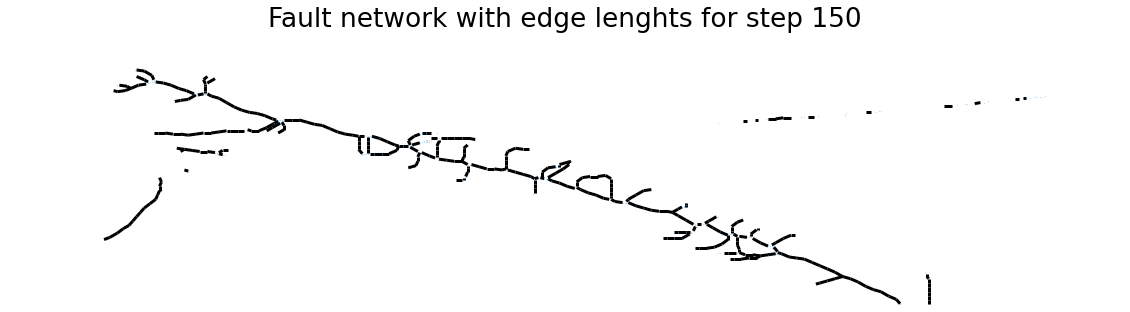

ft_threshold: 2  pixel_distance: 1.5  min_strain_rate: 8e-16


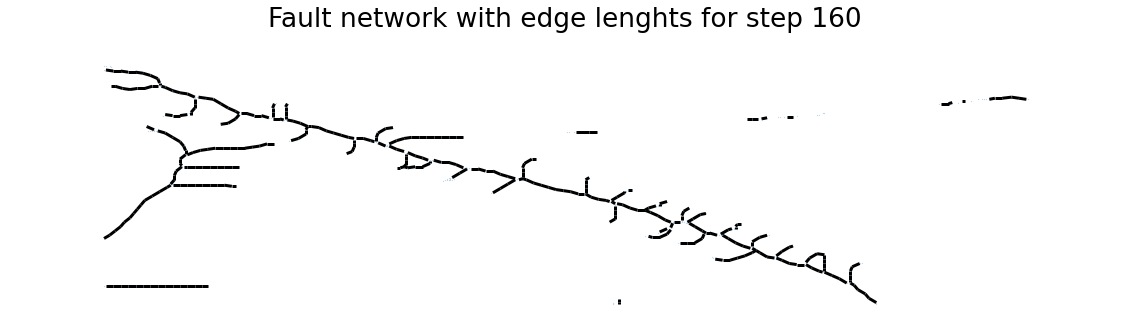

ft_threshold: 2  pixel_distance: 1.5  min_strain_rate: 8e-16


In [5]:
# test of parameters
path = '/home/lxue07/Documents/ThermoMech2d/ForLiang_ThermoMech2D/\
ForLiang_ThermoMech2D/output/AfricaModels2022/Mat/secondary/'
# check if it is refence model 
reference = 0
Gs = []
# first step
inital_step = 135
# min fault length
ft_threshold = 2
# search distance in pixel
pixel_distance =1.5 # in pixel 
# nub strain_rate
min_strain_rate = 7e-14

for step in [150, 160]:
    #for pixel_distance in [3]:
    #for reference in [0, 1]:
        for min_strain_rate in [8e-16]: #7e-14 with fault line extraction
            #step =150   
        #for step in tqdm((range(inital_step, 204))):
            # load data
            import_name = 'Lake_drop_restart_71_1000m_step{}_x_55-105_y_15-40_MEII_zoom.txt'.format(step)
            if reference:
                #print ('reference model')
                import_name = 'Lake_nochange_restart_71_1000m_step{}_x_55-105_y_15-40_MEII_zoom.txt'.format(step)
                    # note that the resolution of pixel is 100m by 100m
            strain_rate = np.genfromtxt(path+import_name)
            # separate the faults from the background using a threshold:
            #min_strain_rate = 3e-15
            threshold = simple_threshold_binary(strain_rate, min_strain_rate)
            # reduce the areas above the threshold to lines using a skeletonize algorithm
            skeleton = skeleton_guo_hall(threshold)
            #convert these lines/skeletons to points/nodes:
            ret, markers = cv2.connectedComponents(skeleton)
            # These points become the nodes of our graph G
            G = nx.Graph()
            node = 0
            for comp in range(1,ret):
                points = np.transpose(np.vstack((np.where(markers==comp))))       
                for point in points:
                    G.add_node(node)
                    G.nodes[node]['pos'] = (point[1], point[0])
                    G.nodes[node]['component'] = comp
                    node += 1  
            # now the graph is an object consisting only of nodes and edges       
            # We calculate the distance between all nodes of a component in a distance matrix 
            # and connect the ones close to each other (<X pixels away):
            #pixel_distance = 1.5 # in pixel 
             # in pixel
            for comp in range(1,ret): 
                points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
                nodes  = [node for node in G if G.nodes[node]['component']==comp]
                dm = distance_matrix(points, points)  
                for n in range(len(points)):
                    # print(n)
                    for m in range(len(points)):
                        if dm[n,m]<pixel_distance and n != m:
                            G.add_edge(nodes[n],nodes[m])

            # Now we can see that neighboring nodes are connected by edges (black lines).
            # This allows us to label the nodes connected to one another as components:
            G = label_components(G)
            # simplify the label 
            G = simplify(G, 2)
            # The structure of network or graph only consists of nodes and edge. Now add strain rate to the nodes
            for node in G.nodes:
                G.nodes[node]['strain_rate'] = strain_rate[int(G.nodes[node]['pos'][1]), int(G.nodes[node]['pos'][0])]
            # Now add length to the edges
            for edge in G.edges:
                G.edges[edge]['length'] = np.linalg.norm(np.array(G.nodes[edge[0]]['pos'])-np.array(G.nodes[edge[1]]['pos']))
            # remove small faults
            #ft_threshold = 1
            short_edges = list(filter(lambda e: e[2] < ft_threshold, (e for e in G.edges.data('length')))) # data in format(node1, node2, data1)
            le_ids = list(e[:2] for e in short_edges)
            # remove filtered edges from graph G
            G.remove_edges_from(le_ids)

            # plot it 
            fig, ax = plt.subplots(figsize=(20,5))
            ax.set_title('Fault network with edge lenghts for step {}'.format(step))
            nx.draw(G, 
                    pos=nx.get_node_attributes(G, 'pos'),
                    #edge_color = np.array([G.edges[edge]['length'] for edge in G.edges]), 
                    node_size=0.01,
                    with_labels = False,
                    width = 3,
                    #cmap = 'RdYlBu',
                    ax=ax)
            #ax.axis('equal')
            ax.set_ylim(250, 0)
            plt.show()
            print ('ft_threshold:',ft_threshold,' pixel_distance:', pixel_distance,' min_strain_rate:',min_strain_rate )
            #fig.savefig('../../Figure/restart_71_intrarift_step{}_intrarift_minft{}_minstrainrt{}_searchpixel{}.eps'.format(step, ft_threshold,min_strain_rate,pixel_distance))
            

    
    


### Fault extraction ThermoMech2D

In [133]:

path = '/home/lxue07/Documents/ThermoMech2d/ForLiang_ThermoMech2D/\
ForLiang_ThermoMech2D/output/AfricaModels2022/Mat/secondary/'
# check if it is refence model 
reference = 0
Gs = []



# weak crust
# name = 'Lake_drop_restart_71_weakcrust2_stepXXX_x_105-160_y_15-40_MEII_zoom'
# inital_step = 421
# end_step = 490

# strong crust
# name = 'Lake_drop_restart_71_strongcrust2_stepXXX_x_105-160_y_15-40_MEII_zoom'
# inital_step = 421
# end_step = 490

#model with Tp30
# name = 'Lake_nochange_restart_71_1000m_Tp30_stepXXX_x_55-105_y_15-40_MEII_zoom'
# inital_step = 264
# end_step = 332

# model with v27
# name = 'Lake_nochange_restart_71_v27_stepXXX_x_55-105_y_15-40_MEII_zoom'
# inital_step = 289
# end_step = 357

# model with lab65
name = 'Lake_nochange_restart_71_LAB65_stepXXX_x_55-105_y_15-40_MEII_zoom'
inital_step = 129
end_step = 196

# primary model with 1000m, justdroop, oneperiod
#name = 'Lake_drop_restart_71_justdroop_stepXXX_x_55-105_y_15-40_MEII_zoom'
#name = 'Lake_drop_restart_71_oneperiod_stepXXX_x_55-105_y_15-40_MEII_zoom'
#name = 'Lake_drop_restart_71_1000m_stepXXX_x_55-105_y_15-40_MEII_zoom'
# inital_step = 135
# end_step = 203


# primary model with 1000m at 81
# name = 'Lake_nochange_restart_81_1000m_stepXXX_x_55-105_y_15-40_MEII_zoom'
# inital_step = 593
# end_step = 660


# 300m, 600, 1500m, 1000m_old, rev 
# name = 'Lake_drop_restart_71_1000m_rev_stepXXX_x_55-105_y_15-40_MEII_zoom'
# inital_step = 367
# end_step = 434


ft_threshold = 2
# search distance in pixel
pixel_distance =1.5# in pixel 
# nub strain_rate
min_strain_rate = 8e-16


#for step in [150, 160]:
for step in tqdm((range(inital_step, end_step+1))):
    # load data
    import_name = name.replace('XXX', str(step))
    import_name = import_name +'.txt'
    if reference:
        #print ('reference model')
        import_name = import_name.replace ('drop', 'nochange')
        #import_name = 'Lake_nochange_restart_71_1000m_step{}_x_105-160_y_15-35_MEII_zoom.txt'.format(step)
    # note that the resolution of pixel is 100m by 100m
    strain_rate = np.genfromtxt(path+import_name)
    # separate the faults from the background using a threshold:
    threshold = simple_threshold_binary(strain_rate, min_strain_rate)
    # reduce the areas above the threshold to lines using a skeletonize algorithm
    skeleton = skeleton_guo_hall(threshold)
    #convert these lines/skeletons to points/nodes:
    ret, markers = cv2.connectedComponents(skeleton)
    # These points become the nodes of our graph G
    G = nx.Graph()
    node = 0
    for comp in range(1,ret):
        points = np.transpose(np.vstack((np.where(markers==comp))))       
        for point in points:
            G.add_node(node)
            G.nodes[node]['pos'] = (point[1], point[0])
            G.nodes[node]['component'] = comp
            node += 1  
    # now the graph is an object consisting only of nodes and edges       
    # We calculate the distance between all nodes of a component in a distance matrix 
    # and connect the ones close to each other (<X pixels away):
    pixel_distance = 1.5 # in pixel 
     # in pixel
    for comp in range(1,ret): 
        points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
        nodes  = [node for node in G if G.nodes[node]['component']==comp]
        dm = distance_matrix(points, points)  
        for n in range(len(points)):
            # print(n)
            for m in range(len(points)):
                if dm[n,m]<pixel_distance and n != m:
                    G.add_edge(nodes[n],nodes[m])

    # Now we can see that neighboring nodes are connected by edges (black lines).
    # This allows us to label the nodes connected to one another as components:
    G = label_components(G)
    # simplify the label 
    G = simplify(G, 2)
    # The structure of network or graph only consists of nodes and edge. Now add strain rate to the nodes
    for node in G.nodes:
        G.nodes[node]['strain_rate'] = strain_rate[int(G.nodes[node]['pos'][1]), int(G.nodes[node]['pos'][0])]
    # Now add length to the edges
    for edge in G.edges:
        G.edges[edge]['length'] = np.linalg.norm(np.array(G.nodes[edge[0]]['pos'])-np.array(G.nodes[edge[1]]['pos']))
    
    # remove small faults
    
    short_edges = list(filter(lambda e: e[2] < ft_threshold, (e for e in G.edges.data('length')))) # data in format(node1, node2, data1)
    le_ids = list(e[:2] for e in short_edges)
    # remove filtered edges from graph G
    G.remove_edges_from(le_ids)
    Gs.append(G)                                                                                       
    # plot it 
#     fig, ax = plt.subplots(figsize=(20,5))
#     ax.set_title('Fault network with edge lenghts for step {}'.format(step))
#     nx.draw(G, 
#             pos=nx.get_node_attributes(G, 'pos'),
#             #edge_color = np.array([G.edges[edge]['length'] for edge in G.edges]), 
#             node_size=0.01,
#             with_labels = False,
#             width = 4,
#             #cmap = 'RdYlBu',
#             ax=ax)
#     #ax.axis('equal')
#     ax.set_ylim(150, 0)
#     plt.show()
    #fig.savefig('../../Figure/restart_71_intrarift_step{}_strainrate_{}.eps'.format(step,min_strain_rate))
#    plot 2
#     fig, ax = plt.subplots(1, 1, figsize=(15,15))
#     ax.set_title('Fault network with edge lenghts for step {}'.format(step))
#     ax.imshow(np.zeros_like(strain_rate), 'gray_r', vmin=0)
#     plot_components(G, node_size=1, ax=ax)
#     ax.set_ylim(150,0)
#     plt.show()
#         # save it as pickle
     
    
#     export_name = import_name.split('.')[0]+'.p'
#     with open(path+export_name, 'wb') as f:
#         # Pickle the 'data' dictionary using the highest protocol available.
#         pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
    
    


100%|██████████| 68/68 [00:35<00:00,  1.93it/s]


### fault correlation through time steps 

In [134]:
# Gs = []
# for step in [159, 169, 179]:
#     import_name = 'Lake_drop_restart_71_1000m_step{}_x_50-190_y_15-38_MEII_zoom.p'.format(step)
#     Gs.append(pickle.load(open(path+import_name, 'rb')))

#time_list = [159, 169, 179]
#for step in tqdm(time_list)
#     import_name0 = 'Lake_drop_restart_71_1000m_step{}_x_50-190_y_15-38_MEII_zoom.p'.format(step)
#     G_0 = pickle.load(open(path+import_name0, 'rb'))
#     import_name1 = 'Lake_drop_restart_71_1000m_step{}_x_50-190_y_15-38_MEII_zoom.p'.format(step+10)
#     G_1 = pickle.load(open(path+import_name1, 'rb'))
for time in tqdm(range(len(Gs)-1)):

    G_0 = Gs[time]
    G_1 = Gs[time+1]
    
    # Correlate two time steps
    # compare all faults between two time steps and re-label them.
    # first we will introduce a new label. We typically extract faults as 
    # components of the graph (i.e. nodes connected to one another). 
    # So let's introduce this new label called 'fault' based on the components:
    for node in G_0:
        G_0.nodes[node]['fault'] = G_0.nodes[node]['component']
    for node in G_1:
        G_1.nodes[node]['fault'] = G_1.nodes[node]['component']

    # To correlate faults across time steps, we want to check how similar each fault from time step 0 
    # is to each fault from time step 1. This will allow us to correlate fault even if they merg or
    # split up between time steps. To do this, we first calculate the similarity and then 
    # correlate faults if their similarity is above a certain threshold:
    def get_nodes(G):
        labels = get_fault_labels(G)
        point_set=[]
        for label in labels:            
            G_fault = get_fault(G, label)
            points = []
            for node in G_fault:
                points.append(G_fault.nodes[node]['pos'])
            point_set.append(points)
        return point_set
    def compute_similarity(set_A, set_B):
        distances = np.zeros((len(set_A), len(set_B)))
        for n, pt_0 in enumerate(set_A):
            for m, pt_1 in enumerate(set_B):
                distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
        return np.mean(np.min(distances, axis=1))
    def correlation_slow(G_0, G_1, R):
        # A function which labels the faults in G_1 according to G_0 using the 
        # minimum radius R
        # Get labels and nodes
        fault_labels_0 = get_fault_labels(G_0)
        fault_labels_1 = get_fault_labels(G_1)
        nodes_0 = get_nodes(G_0)
        nodes_1 = get_nodes(G_1) 
        # Compute similarities    
        smf = np.zeros((len(fault_labels_0), len(fault_labels_1)))
        smb = np.zeros((len(fault_labels_1), len(fault_labels_0)))    
        for n in list(range(len(fault_labels_0))):
            for m in list(range(len(fault_labels_1))):
                smf[n,m] = compute_similarity(nodes_0[n], nodes_1[m])
                smb[m,n] = compute_similarity(nodes_1[m], nodes_0[n])    
        # Determine correlations
        correlations = set()
        for n in list(range(len(fault_labels_0))):
            for m in list(range(len(fault_labels_1))):
                if smf[n,m] < R:
                    correlations.add((fault_labels_0[n], fault_labels_1[m]))
                if smb[m,n] < R:
                    correlations.add((fault_labels_0[n], fault_labels_1[m]))                 
        return correlations, smf, smb
    # set search radius R
    R = 5
    correlations, smf, smb = correlation_slow(G_0, G_1, R=R)
    # Note that we get two similarity matrices, because we compare faults from both time step forward 
    # and backward in time.Most importantly, we can check whether most faults are correlated and then
    # adjust the value R if necessary. R is a measure for the minimal distance between faults 
    # to be correlated, so higher values loosen the correlation and lower values tighten it.
    
    # let's relabel the faults in time step 1 to match time step 0
    def relabel(G_1, correlations):
        # A function, which relabels G_1 using the correlations
        for node in G_1:
            G_1.nodes[node]['correlated']=0 
        lengths = [total_length(get_fault(G_0, correlation[0]), calculate=True) for correlation in correlations]
        lengths, correlations = zip(*sorted(zip(lengths, correlations)))
        for node in G_1:
            for correlation in correlations:
                if G_1.nodes[node]['component'] == correlation[1]:
                    G_1.nodes[node]['fault'] = correlation[0]
                    G_1.nodes[node]['correlated'] = 1   
        max_comp = max(get_fault_labels(G_1))

        G_1_sub = nx.subgraph(G_1, [node for node in G_1 if G_1.nodes[node]['correlated']==0])  
        for label, cc in enumerate(sorted(nx.connected_components(G_1_sub))): 
            for n in cc:
                G_1.nodes[n]['fault'] = label+max_comp+1

        return G_1
    G_1 = relabel(G_1, correlations)
    
    # overwrite
    Gs[time] = G_0
    Gs[time+1] = G_1
    
#     # export 
#     export_name = import_name0.split('.')[0]+'_label.p'
#     with open(path+export_name, 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#         pickle.dump(G_0, f, pickle.HIGHEST_PROTOCOL)
    

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


### fault slip estimation with velocity 

In [135]:
#for step in tqdm([159, 160, 161]):
for step in tqdm((range(inital_step, end_step+1))):
    # load our fault networks extracted 
    # we need to load velocity field to calculate slip

    import_name = name.replace('XXX', str(step))
    import_name = import_name.replace('MEII_zoom', 'velocity_x.txt')
    if reference: 
        import_name = import_name.replace('drop', 'nochange')     
    v_x = np.genfromtxt(path+import_name)
    import_name = name.replace('XXX', str(step))
    import_name = import_name.replace('MEII_zoom', 'velocity_y.txt')
    if reference: 
        import_name = import_name.replace('drop', 'nochange')     
    v_z = np.genfromtxt(path+import_name)
    # velocity field is in m/s 
    #import_name = 'Lake_drop_restart_71_1000m_step{}_x_50-190_y_15-38_MEII_zoom_label.p'.format(step)
    #G = pickle.load(open(path+ import_name, 'rb'))
    G = Gs[step-inital_step]
    # pick up the velocity left and right of each fault, but to do this we first need to calculate 
    # the direction of the fault:
    def calculate_direction(G, cutoff, normalize=True):
        for node in G.nodes:            
            length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff)
            keys = [keys for keys,values in length.items() if values == max(length.values())]        
            if len(keys) >  2:
                (node_0, node_1) = keys[:2]
            if len(keys) == 2:
                (node_0, node_1) = keys
            if len(keys) == 1:
                node_0 = keys[0]            
                length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff-1)
                keys = [keys for keys,values in length.items() if values == max(length.values())]           
                node_1 = keys[0]
            # extrac position
            pt_0 = G.nodes[node_0]['pos']
            pt_1 = G.nodes[node_1]['pos']                  
            # calculate vector              
            dx = pt_0[0] - pt_1[0]
            dy = pt_0[1] - pt_1[1]            
            # write to graph
            G.nodes[node]['dx'] = dx
            G.nodes[node]['dy'] = dy               
        return G
    G = calculate_direction(G, 3)
    # use the direction to calculate the pick-up points:
    def calculate_pickup_points(G, factor):
        H = nx.Graph() 
        for node in G.nodes:
            (x, y) = G.nodes[node]['pos']       
            dx = G.nodes[node]['dx']
            dy = G.nodes[node]['dy']      
            dx = factor * dx
            dy = factor * dy 
            x_p = int(x - dy)
            y_p = int(y + dx)

            x_n = int(x + dy)
            y_n = int(y - dx)
            node_mid = (node, 0)
            H.add_node(node_mid)
            H.nodes[node_mid]['pos'] = (x, y)
            H.nodes[node_mid]['component']  = -1
            node_p = (node, 1)
            H.add_node(node_p)
            H.nodes[node_p]['pos'] = (x_p, y_p)
            H.nodes[node_p]['component']  = -2   
            node_n = (node, 2)
            H.add_node(node_n)
            H.nodes[node_n]['pos'] = (x_n, y_n)
            H.nodes[node_n]['component']  = -3  
            H.add_edge(node_n, node_p)         
        return H
    H = calculate_pickup_points(G, 1)
    # extract velocity
    def extract_attribute(G, image, name):
        (x_max, y_max) = image.shape   
        for node in G:
            y,x = G.nodes[node]['pos']
            if x >= x_max or y>=y_max:
                G.nodes[node][name] = float('nan')        
            else:
                G.nodes[node][name] = image[int(x),int(y)]
        return G

    H = extract_attribute(H, v_x, 'v_x')
    H = extract_attribute(H, v_z, 'v_z')
    def filter_pickup_points(G, H):    
        for node in G:      
            if H.nodes[(node, 1)]['pos'][1] < 0 or H.nodes[(node, 2)]['pos'][1] < 0:

                H.nodes[(node,0)]['v_x'] = 0
                H.nodes[(node,0)]['v_z'] = 0

                H.nodes[(node,1)]['v_x'] = 0
                H.nodes[(node,1)]['v_z'] = 0

                H.nodes[(node,2)]['v_x'] = 0
                H.nodes[(node,2)]['v_z'] = 0
        return H
    H = filter_pickup_points(G, H)
    ## Compute slip and slip rate
    def calculate_slip_rate(G, H, dim):
        if dim == 2:
            for node in H.nodes:
                if node[1] == 0:    # centre point

                    if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                        G.nodes[node[0]]['slip_rate_x'] =  0
                        G.nodes[node[0]]['slip_rate_z'] =  0
                        G.nodes[node[0]]['slip_rate']   =  0
                    else:            
                        G.nodes[node[0]]['slip_rate_x'] =  abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x']))
                        G.nodes[node[0]]['slip_rate_z'] =  abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z']))
                        G.nodes[node[0]]['slip_rate']   =  math.sqrt(G.nodes[node[0]]['slip_rate_x']**2 + G.nodes[node[0]]['slip_rate_z']**2)

        return G
    G = calculate_slip_rate(G, H, dim=2)
    def calculate_slip(G, H, dt, dim):
        if dim == 2:
            for node in H.nodes:
                if node[1] == 0:

                    if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                        G.nodes[node[0]]['slip_x'] =  0
                        G.nodes[node[0]]['slip_z'] =  0
                        G.nodes[node[0]]['slip']   =  0
                    else:            
                        G.nodes[node[0]]['slip_x'] =  abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x']))*dt
                        G.nodes[node[0]]['slip_z'] =  abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z']))*dt
                        G.nodes[node[0]]['slip']   =  math.sqrt(G.nodes[node[0]]['slip_x']**2 + G.nodes[node[0]]['slip_z']**2)

        return G
    G = calculate_slip(G, H, dim=2, dt=1)
    # plot the slip
#     fig, ax = plt.subplots(figsize=(16,10))
#     plot_attribute(G, 'slip', ax =ax, 
#                    #vmax = 1e-12
#                   )
#     ax.matshow(v_x, cmap='gray')
    # plt.xlim([1000, 3500])
    # plt.ylim([600, 0])
    #plt.show()

    # label the fault 
    def get_fault_labels(G):
        labels=set()
        for node in G:
            labels.add(G.nodes[node]['fault'])
        return sorted(list(labels))
    def get_fault(G, n):
        nodes = [node for node in G if G.nodes[node]['fault']==n]
        return G.subgraph(nodes)
    labels = get_fault_labels(G)
    lengths = []
    slips   = []
    for label in labels:
        fault = get_fault(G, label)
        lengths.append(total_length(fault))
        slips.append(np.max([fault.nodes[node]['slip'] for node in fault]))

    # plt.figure(figsize=(12,8))
    # plt.scatter(lengths, slips, c=slips, s=100, cmap='seismic', vmin=0)
    # plt.xlabel('Slip')
    # plt.ylabel('Length')
    # plt.axis('equal')
    # cbar=plt.colorbar()
    # cbar.set_label('Slip')
    # plt.ylim([-50, 50])
    # plt.show()
    # export_name = import_name.split('.')[0]+'_slip.p'
    # with open(path+export_name, 'wb') as f:
    #     # Pickle the 'data' dictionary using the highest protocol available.
    #     pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
    Gs[step-inital_step] = G

100%|██████████| 68/68 [00:11<00:00,  5.75it/s]


### displacement calculation 

In [136]:
# load the net graph with slip attribute 
# Gs = []
# for step in [159, 169]:
#     import_name = 'Lake_drop_restart_71_1000m_step{}_x_50-190_y_15-38_MEII_zoom_label_slip.p'.format(step)
#     Gs.append(pickle.load(open(path+import_name, 'rb')))
# for step in [159, 160, 161]:    
# G_0 = Gs[0]
# G_1 = Gs[1]

# copy over slip to displacement:
def write_slip_to_displacement(G, dim):    
    if dim == 2:
        for node in G:
            G.nodes[node]['heave'] = G.nodes[node]['slip_x']
            G.nodes[node]['throw'] = G.nodes[node]['slip_z']
            G.nodes[node]['displacement'] = G.nodes[node]['slip']

    if dim == 3:
        for node in G:
            G.nodes[node]['heave']   = G.nodes[node]['slip_x']            
            G.nodes[node]['lateral'] = G.nodes[node]['slip_y']
            G.nodes[node]['throw']   = G.nodes[node]['slip_z']
            G.nodes[node]['displacement'] = G.nodes[node]['slip']
    return G

# G_0 = write_slip_to_displacement(G_0, dim=2)
# G_1 = write_slip_to_displacement(G_1, dim=2)

#Now we find the faults common to both time steps:
def get_fault_labels(G):
    labels=set()
    for node in G:
        labels.add(G.nodes[node]['fault'])
    return sorted(list(labels))       

def common_faults(G, H):
    C_G = get_fault_labels(G)
    C_H = get_fault_labels(H)
    return list(set(C_G) & set(C_H))

#cf = common_faults(G_0, G_1)

# plot the fault with label 
# fig, ax = plt.subplots(figsize=(16,4))
# plot_faults(G_0, ax =ax, node_size =1)
# plt.title('time 0')
# # plt.xlim([1000, 3500])
# # plt.ylim([600, 0])
# plt.show()

# fig, ax = plt.subplots(figsize=(16,4))
# plt.title('time 1')
# plot_faults(G_1, ax = ax, node_size =1)
# # plt.xlim([1000, 3500])
# # plt.ylim([600, 0])
# plt.show()

#two more functions: one to get a fault and one to get the displacement with coordinates of the fault.
def get_fault(G, n):
    nodes = [node for node in G if G.nodes[node]['fault']==n]
    return G.subgraph(nodes)

def get_displacement(G, dim):  
    if dim == 2:
        points = np.zeros((len(list(G)),6))    
        for n, node in enumerate(G):
            points[n,0] = node
            points[n,1] = G.nodes[node]['pos'][0]
            points[n,2] = G.nodes[node]['pos'][1]
            points[n,3] = G.nodes[node]['heave']
            points[n,4] = G.nodes[node]['throw']
            points[n,5] = G.nodes[node]['displacement']
    if dim == 3:
        points = np.zeros((len(list(G)),7))    
        for n, node in enumerate(G):
            points[n,0] = node
            points[n,1] = G.nodes[node]['pos'][0]
            points[n,2] = G.nodes[node]['pos'][1]
            points[n,3] = G.nodes[node]['heave']
            points[n,4] = G.nodes[node]['lateral']
            points[n,5] = G.nodes[node]['throw']
            points[n,6] = G.nodes[node]['displacement']
    return points

#Now let's:
#Go through the common faults
#Get their displacement with coordinates
#Find the closest points
#Add the displacement from time 0 to time 1
# for fault in cf:
    
#     points_0 = get_displacement(get_fault(G_0, fault), dim=2)
#     points_1 = get_displacement(get_fault(G_1, fault), dim=2)

#     for n in range(points_1.shape[0]):    
#         index = closest_node(points_1[n,1:3], points_0[:,1:3]) 
        
#         points_1[n,3] += points_0[index][3]
#         points_1[n,4] += points_0[index][4]
#         points_1[n,5] += points_0[index][5]
    
#     G_1 = assign_displacement(G_1, points_1, dim=2)
    
# max_comp = 0

# loop all 
for time in tqdm(range(len(Gs)-1)):

    G_0 = Gs[time]
    G_1 = Gs[time+1]

    if time == 0:
        G_0 = write_slip_to_displacement(G_0, dim=2)  
        Gs[time] = G_0  
    G_1 = write_slip_to_displacement(G_1, dim=2)
    cf = common_faults(G_0, G_1)
    for fault in cf:
        points_0 = get_displacement(get_fault(G_0, fault), dim=2)
        points_1 = get_displacement(get_fault(G_1, fault), dim=2)

        for n in range(points_1.shape[0]):    
            index = closest_node(points_1[n,1:3], points_0[:,1:3]) 

            points_1[n,3] += points_0[index][3]
            points_1[n,4] += points_0[index][4]
            points_1[n,5] += points_0[index][5]
    
        G_1 = assign_displacement(G_1, points_1, dim=2)
    Gs[time+1] = G_1

# plot displacement time series    
# def f(time):
#     fig, ax = plt.subplots(figsize=(16,4))
#     plot_attribute(Gs[time], 'displacement', ax = ax, 
#                    vmax = 1e-11)
# #     plt.xlim([1000, 3500])
#     plt.ylim([200, 0])
#     plt.xlim([0, 1350])
#     plt.show()

# interactive_plot = interactive(f, time=widgets.IntSlider(min=0, max=len(Gs)-1, step=1, layout=Layout(width='900px')))
# output = interactive_plot.children[-1]
# output.layout.width = '1000px'
# interactive_plot

100%|██████████| 67/67 [00:07<00:00,  9.42it/s]


In [137]:
path = '/home/lxue07/Documents/ThermoMech2d/ForLiang_ThermoMech2D/\
ForLiang_ThermoMech2D/output/AfricaModels2022/Mat/'
export_name = name.replace('XXX', str(inital_step)+'-'+str(end_step))
export_name = export_name.replace('MEII_zoom', 'strain'+str(min_strain_rate)+'.p')
if reference:
    print ('reference model')
    export_name = export_name.replace('drop', 'nochange')
with open(path+export_name, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(Gs, f, pickle.HIGHEST_PROTOCOL)

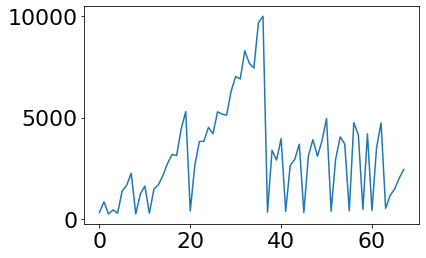

In [138]:
dis_ls = []
for time in list(range(len(Gs))):
    sum_dis = 0
    for n in Gs[time].nodes:
        #print (sum_dis)
        value = Gs[time].nodes[n]['displacement']
        if math.isnan(value):
            #print('---nan---')
            value = 0
        sum_dis += value*60*60*24*265.25*1000 #into kyr
    dis_ls.append(sum_dis)

plt.plot(range(len(dis_ls)), dis_ls)

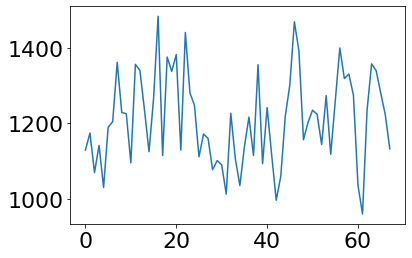

In [139]:
length_ls = []
for time in list(range(len(Gs))):
    sum_dis = 0
    for n in Gs[time].edges:
        #print (sum_dis)
        value = Gs[time].edges[n]['length']
        if math.isnan(value):
            #print('---nan---')
            value = 0
        sum_dis += value
    length_ls.append(sum_dis)

#plt.scatter(range(69), length_ls)
plt.plot(range(len(length_ls)), length_ls)   

ValueError: x and y must have same first dimension, but have shapes (69,) and (68,)

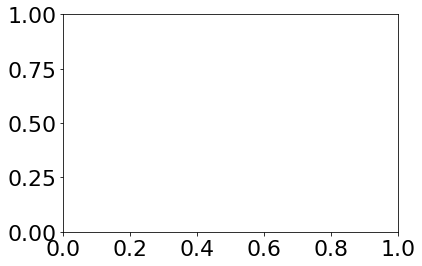

In [90]:
slip_ls = []
for time in list(range(len(Gs))):
    sum_dis = 0
    for n in Gs[time].nodes:
        #print (sum_dis)
        value = Gs[time].nodes[n]['slip']
        if math.isnan(value):
            #print('---nan---')
            value = 0
        sum_dis += value
    slip_ls.append(sum_dis)

plt.plot(range(69), slip_ls)   

In [54]:

print (Gs[0].nodes[1])

{'pos': (55, 55), 'component': 0, 'strain_rate': 1.2718e-15, 'fault': 0, 'dx': 0, 'dy': 4, 'slip_rate_x': 6.999999999995426e-15, 'slip_rate_z': 1.8460000000000065e-13, 'slip_rate': 1.8473267171781005e-13, 'slip_x': 6.999999999995426e-15, 'slip_z': 1.8460000000000065e-13, 'slip': 1.8473267171781005e-13, 'heave': 6.999999999995426e-15, 'throw': 1.8460000000000065e-13, 'displacement': 1.8473267171781005e-13}


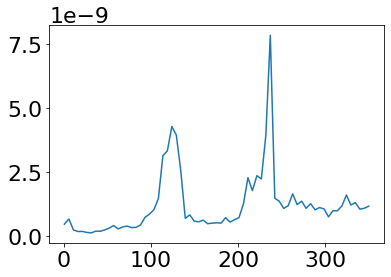

In [20]:
throw_ls = []
for time in list(range(len(Gs))):
    sum_dis = 0
    for n in Gs[time].nodes:
        #print (sum_dis)
        value = Gs[time].nodes[n]['throw']
        if math.isnan(value):
            #print('---nan---')
            value = 0
        sum_dis += value
    throw_ls.append(sum_dis)

plt.plot(list(np.linspace(1,70*5, 69)), throw_ls)   